In [1]:
import pma_python
from pma_python import core
import matplotlib.pyplot as plt
import PIL 
from PIL import Image

image_size (1744, 5089)
tile_size_for_inf 1024
h: 5089 : w: 1744
np_array_shape_of_img (5089, 1744, 3)
empty_intialized_segmented_image_shape (5089, 1744)


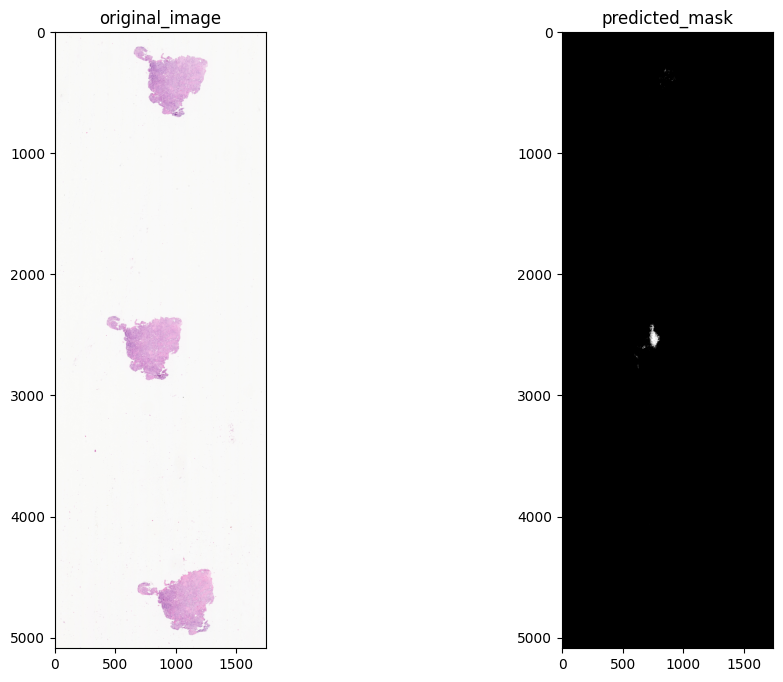

In [13]:
#loading_libraries
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from glob import glob
import random
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import time
from math import ceil
import os
import cv2
import copy
from tqdm import tqdm
import tensorboard
from itertools import permutations
import torch
import torch, math
import torch.fft
import torchvision
from torchvision import transforms
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import nn, einsum
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from einops import reduce
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
torch.cuda.empty_cache()
import torch.optim as optim
from torchvision.transforms import Compose, ToTensor, Normalize
import segmentation_models_pytorch as smp





#preprocessing_before_providing_input_to_model
image_path = '/workspace/copytodgx/image_for_inference/CAIB-T00001993OC01B01P0101HE.tiff'#change_path_for_file
#mask_path = '/workspace/copytodgx/training_node_masks_2x/CAIB-T00000036OC01R01R0506HE.png'
#mask = Image.open(mask_path)
img = Image.open(image_path)
#img = Image.open(image_path).convert('L')
print('image_size',img.size)
h = img.size[1]
w = img.size[0]
tile_size =1024
print('tile_size_for_inf',tile_size)
print('h:',h,':','w:',w)
npimg= np.array(img)
print('np_array_shape_of_img',npimg.shape)
segmented_image = np.zeros((h, w), dtype=np.uint8)
print('empty_intialized_segmented_image_shape',segmented_image.shape)




#loading trained model

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")


model = smp.UnetPlusPlus(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)

model.load_state_dict(torch.load('/workspace/copytodgx/22_SEP_segmentationunetplus_model.pth'),strict=False)#change_path_for_model_path)
model=model.to(device)
model.eval()



#patchwise_prediction_for_patches_and_combining_final_image
for x in range(0, w, tile_size):#cropping patches and predicting patches
        for y in range(0,h,tile_size):
            x_start = x
            y_start = y
            x_end = min(x_start + tile_size,w)
            y_end = min(y_start + tile_size,h)
            
            if x_end-x_start< tile_size:
                x_start=max(x_end-tile_size,0)
            if y_end-y_start<tile_size:
                y_start=max(y_end-tile_size,0)
            tile = npimg[y_start:y_end, x_start:x_end]
            transform = ToTensor()#preprocessing_start
            input_tensor = transform(tile)
            input_tensor = input_tensor.unsqueeze(0).to(device)
            with torch.no_grad():#predicting
                output_tensor = model(input_tensor)#predictions
                squeezed_output = output_tensor.squeeze()  #post processing
                class_indices = torch.argmax(squeezed_output, dim=0)#getting indices for class which is predicted higher than other class by model
                class_indices_np = class_indices.cpu().detach().numpy() #changing from gpu to cpu to numpy
                class_indices_scaled = (class_indices_np * 255).astype(np.uint8) #scaling with 255 so that saving png dont output black with 1 
                segmented_image[y_start:y_end,x_start:x_end] = class_indices_scaled #combining patches to have final image


#visualizing in matplotlib
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 8))

                          
ax1.set_title('original_image')
ax1.imshow(img)
#ax2.set_title('ground_truth_mask')
#ax2.imshow(mask,cmap = 'gray')
ax2.set_title('predicted_mask')
ax2.imshow(segmented_image,cmap = 'gray')

In [ ]:
#withoutpatcheswithresizing

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")


model = smp.UnetPlusPlus(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)

model.load_state_dict(torch.load('/workspace/copytodgx/22_SEP_segmentationunetplus_model.pth'),strict=False)#change_path_for_model_path)
model=model.to(device)
model.eval()

In [ ]:
image_path = '/workspace/copytodgx/image_for_inference/CAIB-T00002006OC01R01R0404HE.tiff'
#mask_path = '/drive4/Anshuman/testing_project/nodel_segmentation/All/training_folder/training_masks_2x/CAIB-T00000036OC01R01R0608HE.png'
image = Image.open(image_path).convert('RGB')
#mask = Image.open(mask_path).convert('L')
im = Image.open(image_path).convert('L')
print('image_size:',image.size)
img_size=(2368,2656)
image=image.resize(img_size)
print('image_resize:',image.size)
transform = ToTensor()
input_tensor = transform(image)
print('shape_after_changing_to_tensor_and_before_unsqueezeing',input_tensor.shape)
input_tensor = input_tensor.unsqueeze(0).to(device)
print('input_shape_to_model_after_unsqueezing',input_tensor.shape)





with torch.no_grad():
    output_tensor = model(input_tensor)
    
    
#post processing to see the outputs

print('output_tensor_shape',output_tensor.shape)
squeezed_output = output_tensor.squeeze()

print('squeezed_output_shape',squeezed_output.shape)
class_indices = torch.argmax(squeezed_output, dim=0) #picking the index with max value out of 2 predicted values.
class_indices_np = class_indices.cpu().detach().numpy()#changing tensor to numpy
class_indices_scaled = (class_indices_np * 255).astype(np.uint8) #for saving as png x 255 is must
print('final_image_shape_after_applying_argmax_and_changing_to_numpy_array_and_multiplying_with_255_to_save_png',class_indices_np.shape)




#visualizing in matplotlib
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize = (12, 8))

                          
ax1.set_title('original_image')
ax1.imshow(image)
ax2.set_title('preprocessed_image_for_input')
ax2.imshow(im,cmap = 'RdBu_r')
#ax3.set_title('ground_truth_mask')
#ax3.imshow(mask,cmap='gist_heat')
ax3.set_title('predicted_mask')
ax3.imshow(class_indices_scaled,cmap = 'gist_heat_r')